In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix

2023-09-30 03:03:14.364240: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
df = pd.read_csv('train_english.csv')
df.head()

,Unnamed: 0,episode,speakers,emotions,utterances
0,0,roseshantstobeadopted.wmv,"['maya', 'indu', 'rosesh', 'indu', 'maya', 'in...","['disgust', 'contempt', 'anger', 'neutral', 'n...","[""What has Indravadan kept in this house? Plea..."
1,1,roseshantstobeadopted.wmv,"['maya', 'rosesh', 'indu', 'rosesh', 'maya', '...","['joy', 'neutral', 'joy', 'sadness', 'neutral'...","['Happy Diwali Beta Rosesh!', 'You Bet Momma.'..."
2,2,roseshantstobeadopted.wmv,"['maya', 'indu', 'maya', 'indu', 'maya', 'maya...","['neutral', 'fear', 'disgust', 'neutral', 'con...","['Radha Bai! Vitthal! Monisha!', 'Listen Maya,..."
3,3,roseshantstobeadopted.wmv,"['sahil', 'monisha', 'sahil', 'monisha', 'sahi...","['anger', 'neutral', 'neutral', 'neutral', 'ne...","['Shut up Rosesh. Bring Monisha water!', 'Whic..."
4,4,roseshantstobeadopted.wmv,"['rosesh', 'maya', 'rosesh', 'maya', 'rosesh',...","['sadness', 'neutral', 'contempt', 'neutral', ...","['Momma, it would be better if you stay away f..."


In [3]:
def getting_speaker_ids(speaker_list):
    speakers = []
    speakers_dict = {}
    for x in speaker_list:
        if x not in speakers:
            speakers.append(x)
    
    for x in speakers:
        speakers_dict[x] = f'speaker {speakers.index(x) + 1}'  # Adding 1 to start numbering from 1

    return speakers_dict

# Example usage:
speakers = ['monisha', 'sahil', 'monisha', 'sahil', 'monisha', 'sahil', 'monisha', 'sahil', 'monisha', 'sahil', 'monisha', 'sahil']
# speakers = ['maya', 'indu', 'rosesh', 'indu', 'maya', 'indu', 'rosesh', 'indu', 'sahil', 'rosesh', 'maya', 'indu', 'sahil', 'monish', 'maya', 'indu', 'maya', 'indu', 'indu', 'maya', 'rosesh', 'maya']

speaker_id = getting_speaker_ids(speakers)
print(speaker_id)
speaker = 'sahil'
print(speaker_id.get(speaker))


{'monisha': 'speaker 1', 'sahil': 'speaker 2'}
speaker 2


In [4]:
def split_emotion(text):
    # Split text into talks
    talks = text.split('.')
    
    # Remove the last entry if it's an empty string (due to '.' for the last one)
    if talks[-1] == '':
        talks.pop(-1)
    
    # Check if there are any talks
    if not talks:
        return "", ""  # Return empty values if there are no talks
    
    # Last talk
    talk = talks[-1]

    # Split emotion and statement
    x_y = talk.split('emotion : [')

    statement = x_y[0]
    emotion = x_y[1][:-1]
    
    # Replace only the statement in place of statement+emotion sentence
    talks[-1] = statement
    utterance = '. '.join(talks)
    
    return utterance, emotion
split_emotion("speaker 1 : What has Indravadan kept in this house? Please why don't you throw out all the baker's things? emotion : [disgust]")

("speaker 1 : What has Indravadan kept in this house? Please why don't you throw out all the baker's things? ",
 'disgust')

In [5]:
def getting_speaker_ids(speaker_list):
    speakers = []
    speakers_dict = {}
    for x in speaker_list:
        if x not in speakers:
            speakers.append(x)
    
    for x in speakers:
        speakers_dict[x] = f'speaker {speakers.index(x) + 1}'  # Adding 1 to start numbering from 1

    return speakers_dict

def split_emotion(text):
    # Split text into talks
    talks = text.split('.')
    
    # Remove the last entry if it's an empty string (due to '.' for the last one)
    if talks[-1] == '':
        talks.pop(-1)
    
    # Check if there are any talks
    if not talks:
        return "", ""  # Return empty values if there are no talks
    
    # Last talk
    talk = talks[-1]

    # Split emotion and statement
    x_y = talk.split('emotion : [')

    statement = x_y[0]
    emotion = x_y[1][:-1]
    
    # Replace only the statement in place of statement+emotion sentence
    talks[-1] = statement
    utterance = '. '.join(talks)
    
    return utterance, emotion



def split_concat(df):
    txt = []
    emotions = []
    for conversation, speakers, emotions in zip(df['utterances'], df['speakers'], df['emotions']):
        utterance = []
        speaker_id = getting_speaker_ids(eval(speakers))
        for talk, speaker, emotion in zip(eval(conversation), eval(speakers), eval(emotions)):
            if len(utterance)==5:
                utterance.pop(0)
            combined = f'{speaker_id.get(speaker)} : {talk} emotion : [{emotion}]'
            utterance.append(combined)
            txt.append('. '.join(utterance))
    txt_and_emotions = [split_emotion(x) for x in txt]
    txt = [f'{item[0]} emotion : ' for item in txt_and_emotions]
    emotions = [item[1] for item in txt_and_emotions]
    new_df = pd.DataFrame(
        {
            'X': txt,
            'Y': emotions
        }
    )
    return new_df

In [6]:
df = pd.read_csv('train_english.csv')
data = split_concat(df)

In [7]:
data.info()
label_encoder = LabelEncoder()
data['Y'] = label_encoder.fit_transform(data['Y'])
print('Classes: ',label_encoder.classes_)
data.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8506 entries, 0 to 8505
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   X       8506 non-null   object
 1   Y       8506 non-null   object
dtypes: object(2)
memory usage: 133.0+ KB
Classes:  ['anger' 'contempt' 'disgust' 'fear' 'joy' 'neutral' 'sadness' 'surprise']


,X,Y
8182,speaker 1 : I asked APSE how did you come emot...,6
4465,speaker 1 : Stubborn stubborn. I will read th...,4
3663,speaker 2 : Were you counting their sneezes? e...,5
458,speaker 2 : What is this Trin Tron trown? emot...,4
2849,"speaker 3 : See Monisha, you must have heard a...",5


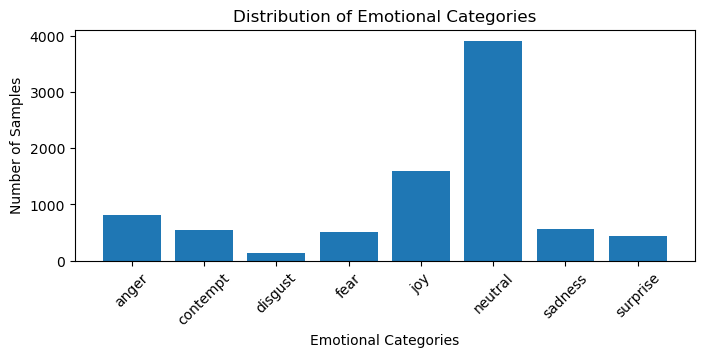

Class --- Count:
anger --- 819
contempt --- 542
disgust --- 127
fear --- 514
joy --- 1596
neutral --- 3909
sadness --- 558
surprise --- 441


In [8]:
label_mapping = ['anger', 'contempt', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']

df = data

# Count the occurrences of each label
label_counts = df['Y'].value_counts().sort_index()

# Create a bar plot
plt.figure(figsize=(8,3))
plt.bar(label_mapping, label_counts)
plt.xlabel('Emotional Categories')
plt.ylabel('Number of Samples')
plt.title('Distribution of Emotional Categories')
plt.xticks(rotation=45)
plt.show()

print("Class --- Count:")
for label, count in zip(label_mapping, label_counts):
    print(f"{label} --- {count}")

In [9]:
class SentimentDataset(Dataset):
    def __init__(self, data, tokenizer, max_length):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        text = self.data.iloc[index]['X']
        label = self.data.iloc[index]['Y']

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        input_ids = encoding['input_ids'].squeeze()
        attention_mask = encoding['attention_mask'].squeeze()

        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'label': torch.tensor(label)
        }

In [10]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_mapping))

#=========================================================================================================

dataset = SentimentDataset(data, tokenizer, max_length= 512)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the pre-trained model

model.to(device)

#=========================================================================================================
#only on karvalo:
num_gpus = 3
device_ids = list(range(num_gpus))
model = torch.nn.DataParallel(model, device_ids=device_ids) 

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i

In [11]:
# Set training parameters
batch_size = 150
learning_rate = 2e-5
epochs = 15

# Create data loader
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Create optimizer and loss function
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

# Training loop with tqdm progress bar
for epoch in range(epochs):
    total_loss = 0
    total_correct = 0  # Initialize a counter for correct predictions
    total_samples = 0  # Initialize a counter for total samples
    model.train()

    # Wrap the data loader with tqdm for a progress bar
    for batch in tqdm(data_loader, desc=f'Epoch {epoch + 1}/{epochs}', leave=False):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        # Compute the mean loss (average loss per batch) across all GPUs
        loss = loss.mean()

        total_loss += loss.item()

        # Calculate accuracy
        _, predicted_labels = torch.max(outputs.logits, 1)  # Get predicted labels
        correct = (predicted_labels == labels).sum().item()  # Count correct predictions
        total_correct += correct
        total_samples += labels.size(0)  # Count total samples in the batch

        loss.backward()
        optimizer.step()

    avg_loss = total_loss / len(data_loader)
    accuracy = total_correct / total_samples  # Calculate accuracy
    print(f'Epoch {epoch + 1}/{epochs} - Loss: {avg_loss:.4f} - Accuracy: {accuracy * 100:.2f}%')

Epoch 1/10:   0%|                                        | 0/64 [00:00<?, ?it/s]/home/iiit/anaconda3/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch 1/10 - Loss: 1.7068


Epoch 2/10 - Loss: 1.5678


Epoch 3/10 - Loss: 1.4726


Epoch 4/10 - Loss: 1.3719


Epoch 5/10 - Loss: 1.2505


Epoch 6/10 - Loss: 1.1303


Epoch 7/10 - Loss: 0.9668


Epoch 8/10 - Loss: 0.8854


Epoch 9/10 - Loss: 0.7213


Epoch 10/10 - Loss: 0.6279


In [12]:
test = pd.read_csv('val_english.csv')
test = test.rename(columns={'english': 'utterances'})  # Use `columns` instead of square brackets
test = split_concat(test)
test.head()

,X,Y
0,speaker 1 : What is this Roseh doing? India is...,neutral
1,speaker 1 : What is this Roseh doing? India is...,neutral
2,speaker 1 : What is this Roseh doing? India is...,neutral
3,speaker 1 : What is this Roseh doing? India is...,contempt
4,speaker 1 : What is this Roseh doing? India is...,neutral


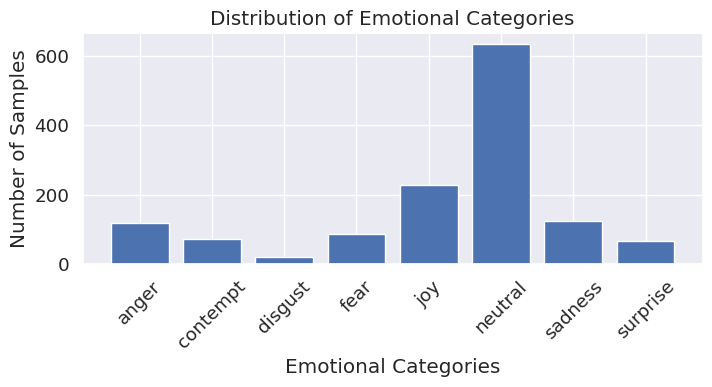

Class --- Count:
anger --- 118
contempt --- 74
disgust --- 21
fear --- 88
joy --- 228
neutral --- 633
sadness --- 126
surprise --- 66


In [15]:
label_mapping = ['anger', 'contempt', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']

df = test

# Count the occurrences of each label
label_counts = df['Y'].value_counts().sort_index()

# Create a bar plot
plt.figure(figsize=(8,3))
plt.bar(label_mapping, label_counts)
plt.xlabel('Emotional Categories')
plt.ylabel('Number of Samples')
plt.title('Distribution of Emotional Categories')
plt.xticks(rotation=45)
plt.show()

print("Class --- Count:")
for label, count in zip(label_mapping, label_counts):
    print(f"{label} --- {count}")

In [13]:
label_mapping = ['anger', 'contempt', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']

def get_accuracy_and_confusion_matrix(data_df, model, tokenizer, batch_size=16, device='cuda'):
    predicted_labels = []

    num_batches = (len(data_df) - 1) // batch_size + 1

    for i in range(num_batches):
        batch_texts = data_df['X'][i * batch_size: (i + 1) * batch_size]

        encoded_inputs = tokenizer.batch_encode_plus(batch_texts,
                                                     padding=True,
                                                     truncation=True,
                                                     max_length=512,
                                                     return_tensors='pt')

        with torch.no_grad():
            model.to(device)
            model_outputs = model(**encoded_inputs.to(device))

        batch_predicted_labels = torch.argmax(model_outputs.logits, dim=1)
        predicted_labels.extend(batch_predicted_labels.tolist())

    predicted_labels = predicted_labels[:len(data_df)]
    predicted_labels = [label_mapping[x] for x in predicted_labels]
    return np.array(predicted_labels)

# With 10 epochs

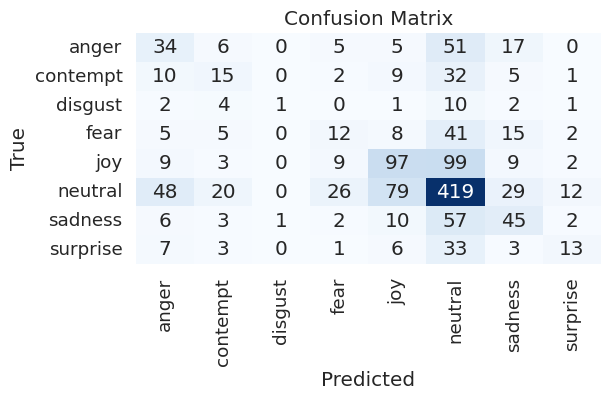

0.46971935007385524

In [14]:
predictions = get_accuracy_and_confusion_matrix(test, model, tokenizer)

y= np.array(test['Y'])

confusion = confusion_matrix(y, predictions, labels=label_mapping)
confusion_df = pd.DataFrame(confusion, index=label_mapping, columns=label_mapping)

plt.figure(figsize=(6, 3))
sns.set(font_scale=1.2)
sns.heatmap(confusion_df, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

accuracy_score(y, predictions)

# With 15 epochs

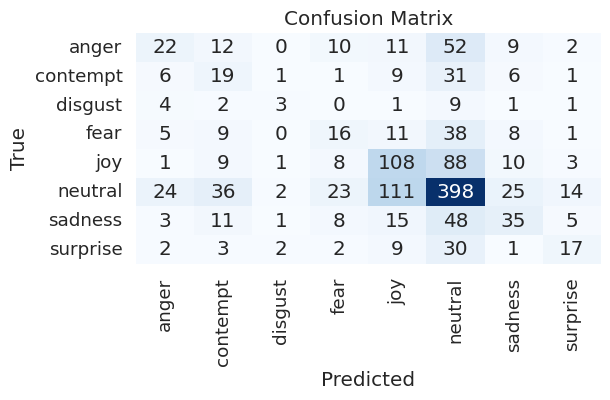

0.4564254062038405

In [20]:
predictions = get_accuracy_and_confusion_matrix(test, model, tokenizer)

y= np.array(test['Y'])

confusion = confusion_matrix(y, predictions, labels=label_mapping)
confusion_df = pd.DataFrame(confusion, index=label_mapping, columns=label_mapping)

plt.figure(figsize=(6, 3))
sns.set(font_scale=1.2)
sns.heatmap(confusion_df, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

accuracy_score(y, predictions)